In [1]:
!pip install keras==2.6.*
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
!pip install nltk
import nltk
nltk.download('wordnet')
from nltk.tokenize import wordpunct_tokenize
nltk.download('all')
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
string.punctuation

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras import losses
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import keras.backend as k


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nl

In [2]:
df = pd.read_csv("Twitter_Data.csv")

In [3]:
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [4]:
pd.set_option("max_colwidth",800)
df.head()

,clean_text,category
0,when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples,-1.0
1,talk all the nonsense and continue all the drama will vote for modi,0.0
2,what did just say vote for modi welcome bjp told you rahul the main campaigner for modi think modi should just relax,1.0
3,asking his supporters prefix chowkidar their names modi did great service now there confusion what read what not now crustal clear what will crass filthy nonsensical see how most abuses are coming from chowkidars,1.0
4,answer who among these the most powerful world leader today trump putin modi may,1.0


In [5]:
df['category'].value_counts()

 1.0    72250
 0.0    55213
-1.0    35510
Name: category, dtype: int64

In [6]:
df['category']= df['category'].map({-1.0: 'Negative', 0.0: 'Neutral',1.0:'Positive'})

In [7]:
df['category'].value_counts()

Positive    72250
Neutral     55213
Negative    35510
Name: category, dtype: int64

Text(0.5, 1.0, 'Dataset labels distribuition')

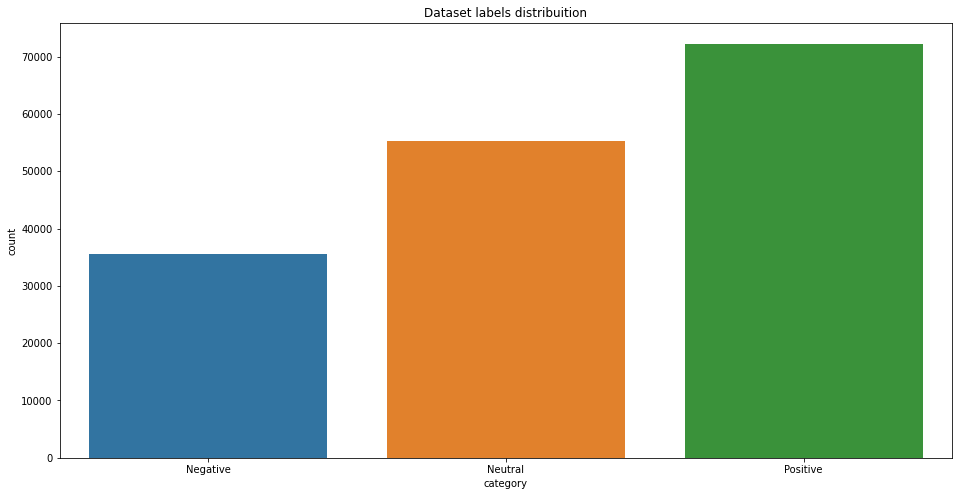

In [8]:
import seaborn as sns
plt.figure(figsize=(16,8))
sns.countplot(x ='category', data= df )
plt.title("Dataset labels distribuition")

In [9]:
df.head()

,clean_text,category
0,when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples,Negative
1,talk all the nonsense and continue all the drama will vote for modi,Neutral
2,what did just say vote for modi welcome bjp told you rahul the main campaigner for modi think modi should just relax,Positive
3,asking his supporters prefix chowkidar their names modi did great service now there confusion what read what not now crustal clear what will crass filthy nonsensical see how most abuses are coming from chowkidars,Positive
4,answer who among these the most powerful world leader today trump putin modi may,Positive


In [10]:
df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [11]:
df= df.dropna()

In [12]:
df.isnull().sum()

clean_text    0
category      0
dtype: int64

In [13]:
df.shape

(162969, 2)

In [14]:
n= len(df.index)
print(n)

162969


In [15]:
def pre_clean(text):
  No_of_words_in_sentence=[]
  relevant_text_train = text
  tokenized_data_train = relevant_text_train.apply(lambda x: wordpunct_tokenize(x.lower()))
  def remove_punctuation(text):
    no_punctuation = []
    for w in text:
        if w not in string.punctuation:
            no_punctuation.append(w)
    return no_punctuation
  no_punctuation_data_train = tokenized_data_train.apply(lambda x: remove_punctuation(x))
  stop_words = stopwords.words('english')
  filtered_sentence_train = [w for w in no_punctuation_data_train if not w in stop_words]
  filtered_sentence_train = pd.Series(filtered_sentence_train)
  def lemmatize_text(text):
    lem_text = [WordNetLemmatizer().lemmatize(w,pos = 'v') for w in text]
    return lem_text
  lemmatized_data_train = filtered_sentence_train.apply(lambda x:lemmatize_text(x))
  def stem_text(text):
    stem_text = [PorterStemmer().stem(w) for w in text]
    return stem_text
  stemmed_data_train = lemmatized_data_train.apply(lambda x:stem_text(x))
  for i in range(0,n):
    a=len(stemmed_data_train[i])
    No_of_words_in_sentence.append(a)
  No_of_words_in_sentence = pd.Series(No_of_words_in_sentence) 
  def word_to_sentence(text):
    text_sentence = " ".join(text)
    return text_sentence
  clean_data_train = stemmed_data_train.apply(lambda x:word_to_sentence(x))
  return(clean_data_train, No_of_words_in_sentence)

In [16]:
clean_data_train, No_of_words_in_sentence = pre_clean(df['clean_text'])

In [17]:
clean_data_train = pd.concat([clean_data_train, No_of_words_in_sentence],  axis=1)
clean_data_train.rename(columns = {0:'clean_text',1:'No_of_words_in_sentence'}, inplace = True)
clean_data_train['category']= df['category']
clean_data_train

,clean_text,No_of_words_in_sentence,category
0,when modi promis “ minimum govern maximum govern ” expect him begin the difficult job reform the state whi do take year get justic state should and not busi and should exit psu and templ,35,Negative
1,talk all the nonsens and continu all the drama will vote for modi,13,Neutral
2,what do just say vote for modi welcom bjp tell you rahul the main campaign for modi think modi should just relax,22,Positive
3,ask hi support prefix chowkidar their name modi do great servic now there confus what read what not now crustal clear what will crass filthi nonsens see how most abus be come from chowkidar,34,Positive
4,answer who among these the most power world leader today trump putin modi may,14,Positive
...,...,...,...
162964,whi these 456 crore pay neerav modi not recov from congress leader thi hard earn money tax payer,18,Positive
162965,dear rss terrorist payal gawar what about modi kill 1000 plu muslim listen dysfunct littl pest take your pea size brain bleat somewher els anyon who commit crime crimin irrespect hindumuslim stop give crimin religi twist,36,Neutral
162966,do you cover her interact forum where she leav,9,Neutral
162967,there big project come into india modi dream project but not happen realiti,13,Negative


In [18]:
X= clean_data_train['clean_text']
y = clean_data_train['category']

In [19]:
from keras.preprocessing.text import Tokenizer
max_words = 5000
max_len=60

def tokenize_pad_sequences(text):
    rep = [one_hot(words,5000) for words in text]
    X = pad_sequences(rep, padding='pre', maxlen=max_len)
    return X

print('Before Tokenization & Padding \n', df['clean_text'][0])
X = tokenize_pad_sequences(clean_data_train['clean_text'])
print('After Tokenization & Padding \n', X)

Before Tokenization & Padding 
 when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
After Tokenization & Padding 
 [[   0    0    0 ... 1891  365 2343]
 [   0    0    0 ...  116 3632  256]
 [   0    0    0 ... 3637 2924  687]
 ...
 [   0    0    0 ...  441 4250 1333]
 [   0    0    0 ... 2917 1098 3685]
 [   0    0    0 ... 1851 1410 3632]]


In [20]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (97781, 60) (97781, 3)
Validation Set -> (32594, 60) (32594, 3)
Test Set -> (32594, 60) (32594, 3)


In [21]:
import keras.backend as K

def f1_score(precision, recall):
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [22]:
vocab_size = 5000
embedding_size = 32
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


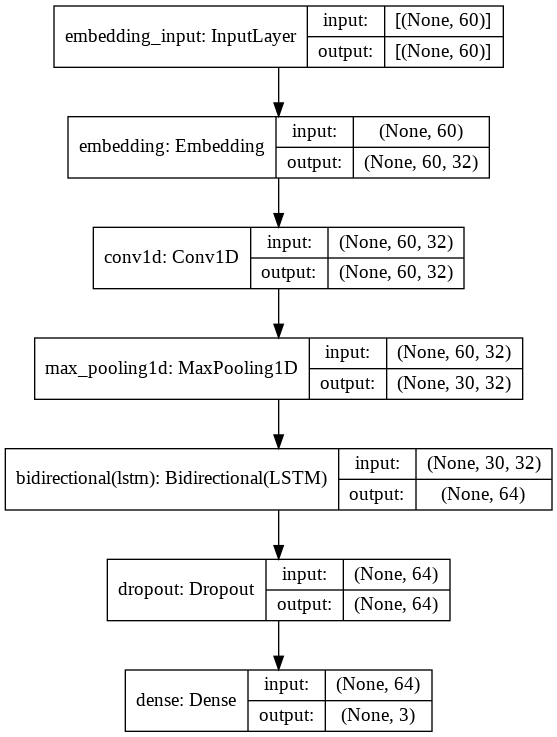

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [24]:
print(model.summary())
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])
batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 32)            160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 60, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 30, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 179,939
Trainable params: 179,939
Non-trainable params: 0
__________________________________________________

In [25]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.7850
Precision : 0.8134
Recall    : 0.7454
F1 Score  : 0.7779


In [32]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.9635929763317108)

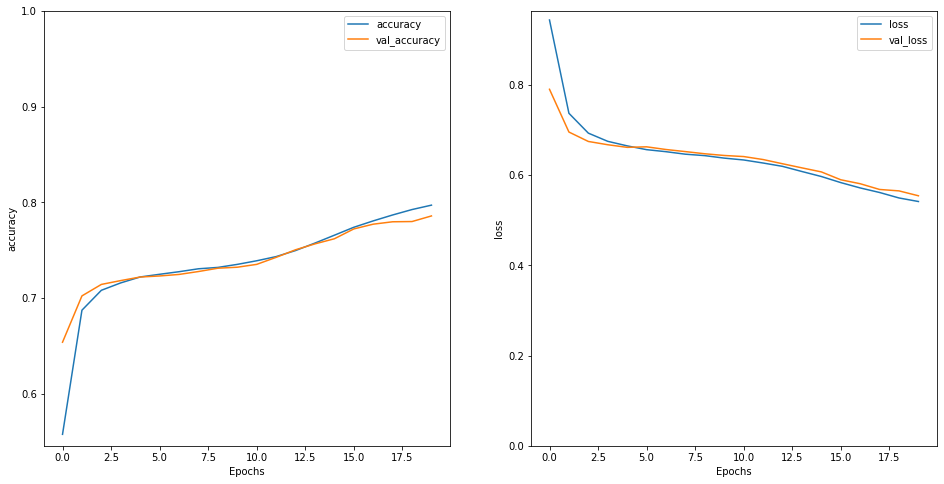

In [33]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [26]:
model.save('model.h5')
print('model saved')

model saved


In [27]:
from keras.models import load_model
model = load_model('model.h5')

def predict_class(text):
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    xt = tokenize_pad_sequences(text)
    yt = model.predict(xt).argmax(axis=1)
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [28]:
predict_class(['"I hate talking to people'])

The predicted sentiment is Negative


In [29]:
predict_class(['He is a best singer india ever had seen'])

The predicted sentiment is Positive


In [30]:
predict_class(['the behaviour is neutral'])

The predicted sentiment is Neutral
